In [1]:
# pendulum_control.ipynb
# This notebook is used for testing control of a pendulum using basic input correlation learning.

# By Sergio Verduzco Flores        July 2017

from draculab import *
from matplotlib import pyplot as plt
import time

The simulation set in the following cell is for a pendulum with no perturbations, under the action of a single input unit that provides torque at the joint. The unit receives all of the pendulum's kinematic and dynamic variables, and adjusts those inputs using the input correlation learning rule, as described in http://www.mitpressjournals.org/doi/abs/10.1162/neco.2006.18.6.1380#.WPhOL0clE58, and implemented in the *synapses.input_correlation_synapse* class.

As described in the *plants.pendulum* class documentation, the pendulum has two state variables: angle and angular velocity. Those variables can adopt negative values, but we assume that the sigmoidal units that represent them only have positive outputs. To properly represent the pendulum outputs we use a sigmoidal unit that grows when it becomes more positive, and one that grows when it becomes more negative. This is achieved by changing the sign of the synapses at the connections from the pendulum to the sigmoidal units. 

Among the things that can be seen in these simulations is the effect of gravity (the 'g' plant parameter), and the effect of having different desired angles (the 'des_ang' attribute of ic_control), and learning rates.

In [2]:
class ic_control():
    def __init__(self):
    ########### Create parameter dictionaries for network, plant, and units
        # parameter dictionary for the network
        self.net_params = {'min_delay' : 0.01, 'min_buff_size' : 4, 'rtol' : 1e-5, 'atol' : 5e-6 } 
        # This pendulum has no gravity (horizontal pendulum). Initial position is 45 degrees.
        self.plant_params = {'type' : plant_models.pendulum, 'length' : 2., 'inp_gain' : 10., 'g' : 0.,
                        'mass' : 10., 'mu' : 1., 'init_angle' : np.pi/2., 'init_ang_vel' : -0.2}
        # parameter dictionary for the afferent input units
        self.aff_unit_pars = { 'init_val' : 0.5, 'type' : unit_types.sigmoidal, 'tau_fast' : 0.01,
                          'slope' : [0.5, 0.5, 0.2, 0.2], 'thresh' : [0.2, 0.2, 0.2, 0.2], 'tau' : 0.02} 
        # parameter dictionary for the "controller" unit using input correlation
        self.ic_unit_pars = {'init_val' : 0.5, 'type' : unit_types.linear, 'tau' : 0.02}
        # parameter dictionary for the source unit providing the error signal to the ic unit
        self.err_unit_pars = {'init_val' : 0., 'tau_fast' : 0.01, 'tau_mid' : 0.1, 
                              'function' : lambda x:None, 'type' : unit_types.source}

    ########### Create parameter dictionaries for the synapses and connections
        self.pend2affs_syn_spec = {'init_w' : [1., -1., 1., -1.], 'type' : synapse_types.static}
        self.ic2pend_syn_spec = {'init_w' : 1., 'type' : synapse_types.static}
        self.affs2ic_syn_spec = {'init_w' : 0., 'lrate' : 15., 'input_type' : 'pred', 'type' : synapse_types.inp_corr}
        self.err2ic_syn_spec = {'init_w' : 2., 'lrate' : 0.1, 'input_type' : 'error', 'type' : synapse_types.inp_corr}

        # port map: first two units receive angle, second two receive angular velocity
        self.pend2affs_conn_spec = { 'port_map' : [ [(0,0)], [(0,0)], [(1,0)], [(1,0)] ], 'delays' : 0.01}
        self.ic2pend_conn_spec = {'inp_ports' : [0], 'delays' : 0.02}
        self.affs2ic_conn_spec = {'rule' : 'all_to_all', 'delay' : 0.02}
        self.err2ic_conn_spec = {'rule' : 'all_to_all', 'delay' : 0.02}
        
    def sq_ang_dev(self, t): # a squared error, has no direction information
        pend_ang = self.net.plants[self.pend].get_angle(t) # angle modulo 2pi
        ang_diff = self.des_ang - pend_ang
        # There are two angle differences, depending on the 'direction' we measure. We want the smallest.
        return ( (ang_diff + np.pi) % (2*np.pi) - np.pi )**2
    
    def ang_dev(self, t): # using this as the error, the ic effectively turns into a proportional controller
        pend_ang = self.net.plants[self.pend].get_angle(t) # angle modulo 2pi
        # Smallest rotation required to go from pend_ang to des_ang:
        return (self.des_ang - pend_ang + np.pi) % (2*np.pi) - np.pi
        
    def initialize(self):
    ########### Create network, plant, and input units
        self.net = network(self.net_params)  # creating a network
        self.pend = self.net.create(1, self.plant_params) # a pendulum
        self.affs = self.net.create(4, self.aff_unit_pars) # afferent units
        self.ic = self.net.create(1, self.ic_unit_pars) # controller unit
        self.err = self.net.create(1, self.err_unit_pars) # error unit

    ########### Set the error function
        self.des_ang = 0. #np.pi/2. # desired angle in range [0,2*pi)
        self.net.units[self.err[0]].set_function( self.ang_dev )

    ########### Connect
        # afferents to controller
        self.net.connect(self.affs, self.ic, self.affs2ic_conn_spec, self.affs2ic_syn_spec)
        # error to controller
        self.net.connect(self.err, self.ic, self.err2ic_conn_spec, self.err2ic_syn_spec)  
        # controller to plant
        self.net.set_plant_inputs(self.ic, self.pend, self.ic2pend_conn_spec, self.ic2pend_syn_spec)
        # plant to afferents
        self.net.set_plant_outputs(self.pend, self.affs, self.pend2affs_conn_spec, self.pend2affs_syn_spec)  

    ########## To keep track of error 'derivative', use an isolated source unit
        track_unit_pars = {'init_val' : 0., 'function' : lambda x:None, 'type' : unit_types.source}
        self.track = self.net.create(1, track_unit_pars)
        self.net.units[self.track[0]].set_function( lambda x : self.net.units[self.ic[0]].err_diff )

    def simulate(self, sim_time):
    ########### Simulate
        start_time = time.time()
        self.times, self.unit_stor, self.plant_stor = self.net.run(sim_time)
        print('Execution time: %s seconds' % (time.time() - start_time))

    def plot_results(self):
        # Plot the state variables of the pendulum
        fig_pend = plt.figure(figsize=(18,6))
        plt.subplot(211); plt.xlabel('time [s]'); plt.ylabel('angle [rad]')
        plt.plot(self.times, (self.plant_stor[0][:,0]+np.pi)%(2.*np.pi)-np.pi, 'b', figure=fig_pend)
        plt.plot(self.times, [self.des_ang]*len(self.times), 'k', linewidth=1)
        plt.subplot(212); plt.xlabel('time [s]'); plt.ylabel('ang vel [rad/s]')
        plt.plot(self.times, self.plant_stor[0][:,1], 'r', figure=fig_pend)

        # Plot the activity of the afferent units
        fig_affs = plt.figure(figsize=(18,6))
        for a in self.affs:
            plt.plot(self.times, self.unit_stor[a], label="ID={0}".format(a))
        plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=2, shadow=True, title="afferent units")

        # Plot the activity of the error and controller units
        fig_cont = plt.figure(figsize=(18,5))
        plt.plot(self.times, self.unit_stor[self.err[0]], label="error")
        plt.plot(self.times, self.unit_stor[self.ic[0]], label="control")
        plt.plot(self.times, self.unit_stor[self.track[0]], label="err_diff")
        plt.plot(self.times, np.zeros(len(self.times)), 'k', linewidth=1)
        plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=1, shadow=True)

        plt.show()

Execution time: 10.33795976638794 seconds


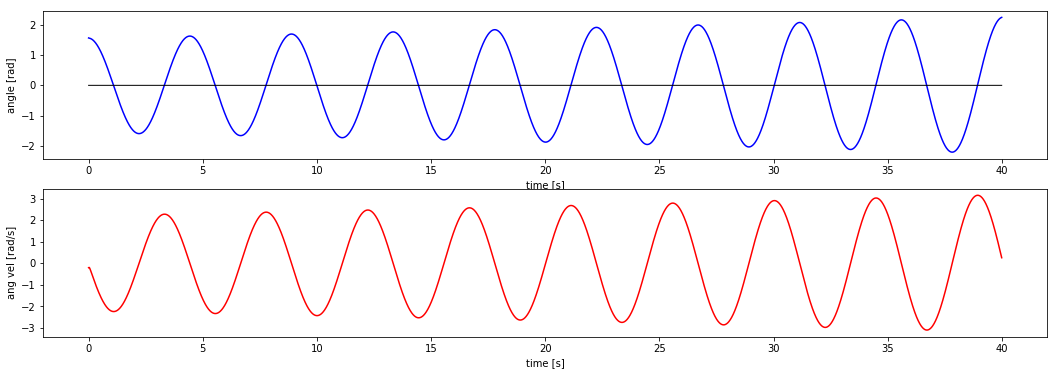

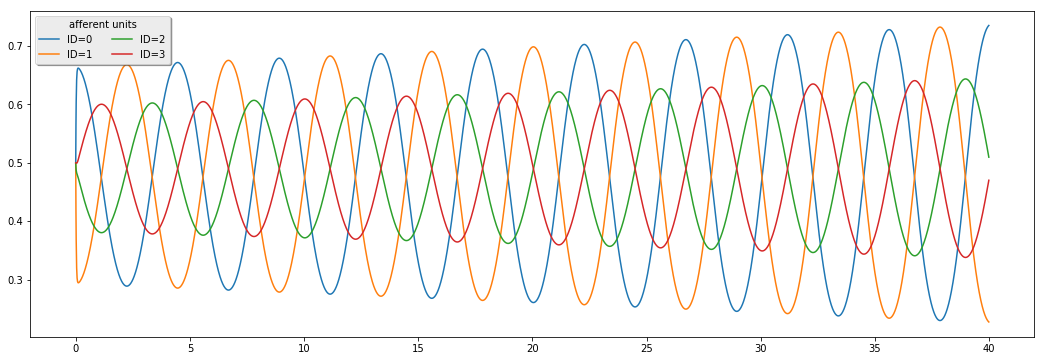

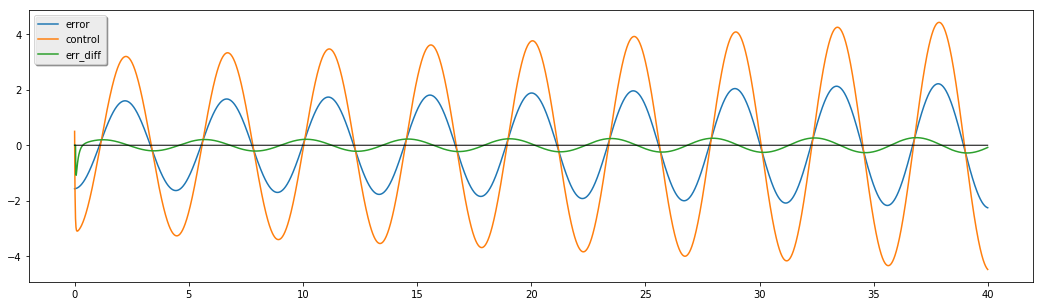

In [3]:
""" Simulate using no IC learning """
icc = ic_control()
icc.affs2ic_syn_spec['lrate'] = 0. # the learning rate of the inputs using the input correlation rule
icc.initialize()
icc.simulate(40.)
icc.plot_results()

Execution time: 11.922083377838135 seconds


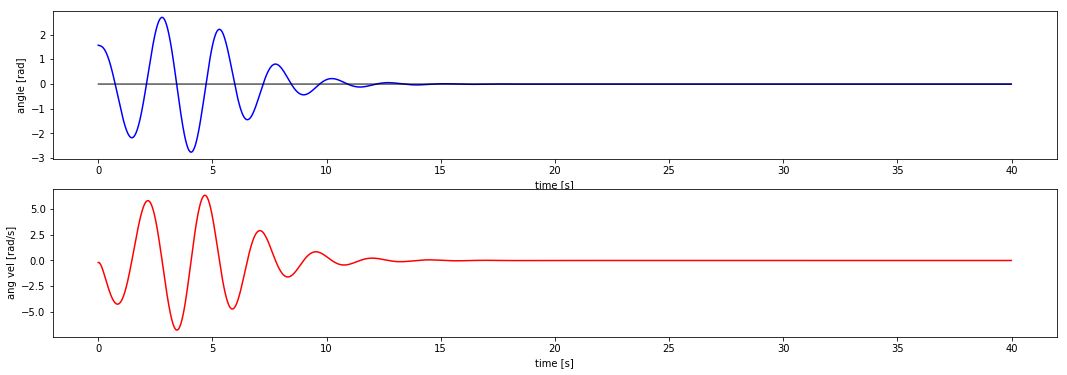

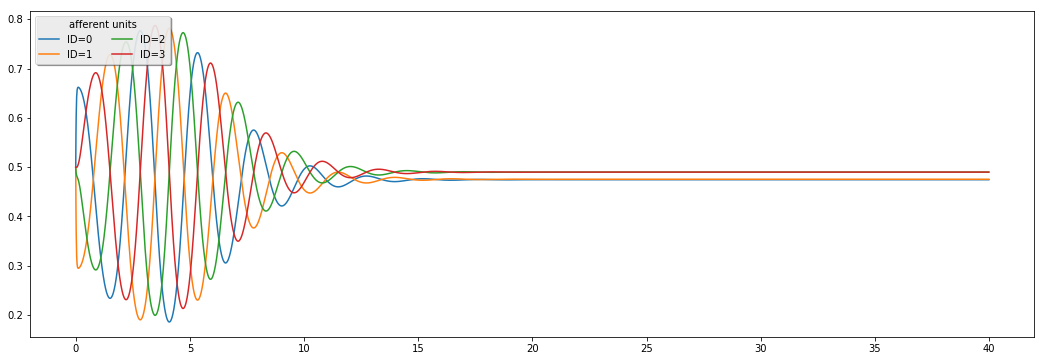

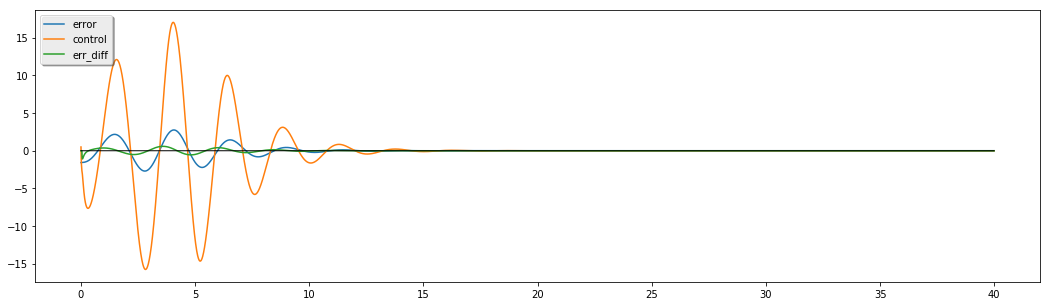

In [4]:
""" Simulate using IC learning """
icc = ic_control()
icc.affs2ic_syn_spec['lrate'] = 40. # the learning rate of the inputs using the input correlation rule
icc.initialize()
icc.simulate(40.)
icc.plot_results()